In [1]:
import math
import numpy as np
import re
# used to parse values into the url
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pandas as pd
from textwrap import wrap
from Bio import Entrez
from scipy import stats
import pickle

In [2]:
#Kozak Consensus Scoring System

#0=A, 1=T, 2=G, 3=C, 4=N (Missing)
weights = np.array([
       [0.04210526, 0.        , 0.03157895, 0.05263158, 0.        ],
       [0.04210526, 0.05263158, 0.10526316, 0.0625    , 0.        ],
       [0.03157895, 0.04210526, 0.05263158, 0.07368421, 0.        ],
       [0.03157895, 0.01052632, 0.04210526, 0.05263158, 0.        ],
       [0.08421053, 0.07368421, 0.18947368, 0.10526316, 0.        ],
       [0.04210526, 0.05263158, 0.05263158, 0.08421053, 0.        ],
       [0.12631579, 0.0625    , 0.12631579, 0.21052632, 0.        ],
       [0.83157895, 0.12631579, 0.65263158, 0.16842105, 0.        ],
       [0.15789474, 0.06315789, 0.11578947, 0.2       , 0.        ],
       [0.21052632, 0.09473684, 0.31578947, 0.51578947, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.24210526, 0.16666667, 0.53684211, 0.13684211, 0.        ],
       [0.15789474, 0.09473684, 0.09473684, 0.24210526, 0.        ],
       [0.05263158, 0.08421053, 0.14736842, 0.09473684, 0.        ],
       [0.07216495, 0.05263158, 0.10526316, 0.06315789, 0.        ],
       [0.        , 0.        , 0.        , 0.05263158, 0.        ],
       [0.05263158, 0.05263158, 0.10526316, 0.09473684, 0.        ],
       [0.04210526, 0.03157895, 0.05263158, 0.04210526, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.04210526, 0.04210526, 0.08421053, 0.07368421, 0.        ],
       [0.0625    , 0.04210526, 0.09473684, 0.05263158, 0.        ]
])

#Below function scores using consensus kozak motif scores
def similarity_score(sequence):
                
    #We need consistency and flexibility:
    sequence = sequence.upper().replace('U','T')
    
    holder=''
    
    for i in sequence:
        if i in 'ACTG':
            holder+=i
            
    sequence=holder
    

    
    numbers=[0]*len(sequence)
    
    for k in np.arange(len(sequence)):
        if sequence[k]=='A':
            numbers[k] = 0
        elif sequence[k]=='T':
            numbers[k] = 1
        elif sequence[k]=='G':
            numbers[k] = 2
        elif sequence[k]=='C':
            numbers[k] = 3
        else:
            numbers[k]=4
                
    
    score = 0
    for k in np.arange(len(numbers)):
        score += weights[k][numbers[k]]
            
    max_score = np.sum(weights.max(axis=1))
    
    score = score/max_score
    
    #Final scoring value: we take the maximum possible score 
    #calculated, and return our score divided by the maximum (to normalize from range 0 to 1) 
    
    return(score)

In [3]:
noncanonical=pd.read_excel('Alternative TICs in Genes Associated with Cancer.xlsx')
noncanonical['Codon']=[i[11:14] for i in noncanonical['Translation Initiation Codon (TIC) with Flanking Sequence']]
noncanonical=noncanonical[noncanonical['Codon'].isin(['CTG','GTG','TTG','ACG','AGG','AAG','ATC','ATA','ATT'])]

In [4]:
def find_upstream(sequence,noncanonical_start):
    
    seq=sequence[0:noncanonical_start]
    
    sites=[m.start() for m in re.finditer('CTG',seq)]+[m.start() for m in re.finditer('GTG',seq)]+\
[m.start() for m in re.finditer('TTG',seq)]+[m.start() for m in re.finditer('ACG',seq)]+\
[m.start() for m in re.finditer('AGG',seq)]+[m.start() for m in re.finditer('AAG',seq)]+\
[m.start() for m in re.finditer('ATC',seq)]+[m.start() for m in re.finditer('ATA',seq)]+\
[m.start() for m in re.finditer('ATC',seq)]+[m.start() for m in re.finditer('ATG',seq)]

    return(len(sites))

In [5]:
def find_upstream_atg(sequence,CDS_start):
    seq=sequence[0:CDS_start]

    sites=[m.start() for m in re.finditer('ATG',seq)]
    
    return(len(sites))

In [6]:
Entrez.email ="email.here@email.com"

seqs=[]
distances=[]
upstream_lengths=[]
tot_lengths=[]
distance_noncanonical=[]
codons_upstream = []
codons_total_5primeregion=[]
atgs_total_5primeregion=[]
genes=[]
atg_codons_total=[]



for nu_id,noncan_seq,gene in zip(noncanonical['Nucleotide ID of Transcript'],noncanonical['Translation Initiation Codon (TIC) with Flanking Sequence'],noncanonical['Gene ']):
    try:
        request=Entrez.epost('nucleotide',id=nu_id)    
        result = Entrez.read(request)
        webEnv = result["WebEnv"]
        queryKey = result["QueryKey"]
        handle = Entrez.efetch(db="nucleotide",retmode="xml", webenv=webEnv, query_key=queryKey)
        for index,r in enumerate(Entrez.parse(handle)):
            try:
                CDS_start= int(re.search(r"'GBFeature_key\': \'CDS\', \'GBFeature_location\': \'(.*?)\', \'GBFeature_intervals\': ",str(r)).group(1).split('..')[0])-1
                seq=r['GBSeq_sequence'].upper()
                noncanonical_start = seq.find(noncan_seq.replace(' ',''))+10
                distances+=[CDS_start-noncanonical_start]
                tot_lengths+=[len(seq)]
                upstream_lengths+=[CDS_start]
                distance_noncanonical+=[noncanonical_start]
                seqs+=[seq]
                codons_upstream+=[find_upstream(seq,noncanonical_start+2)]
                codons_total_5primeregion+=[find_upstream(seq,CDS_start+2)]
                atgs_total_5primeregion+=[find_upstream_atg(seq,CDS_start+2)]
                atg_codons_total+=[find_upstream_atg(seq,len(seq))]

                genes+=[gene]
                

            except:
                try:
                    seq=r['GBSeq_sequence'].upper()
                    CDS_start= int(re.search(r"{'GBFeature_key': 'CDS', 'GBFeature_location': '(.*?)', 'GBFeature_intervals': ",str(r)).group(1).split('..')[0])-1
                    noncanonical_start = seq.find(noncan_seq.replace(' ',''))+10
                    distances+=[CDS_start-noncanonical_start]
                    tot_lengths+=[len(seq)]
                    upstream_lengths+=[CDS_start]
                    distance_noncanonical+=[noncanonical_start]
                    seqs+=[seq]
                    codons_upstream+=[find_upstream(seq,noncanonical_start+2)]
                    codons_total_5primeregion+=[find_upstream(seq,CDS_start+2)]
                    atgs_total_5primeregion+=[find_upstream_atg(seq,CDS_start+2)]
                    atg_codons_total+=[find_upstream_atg(seq,len(seq))]

                    genes+=[gene]


                except:
                    print(nu_id)
            
    except:
        print(nu_id)
    
    time.sleep(0.15)

In [7]:
for CDS_pos,noncan_pos,gene in zip(upstream_lengths,distance_noncanonical,genes):
    if noncan_pos>CDS_pos:
        print(CDS_pos,noncan_pos,gene)

96 228 EPB41L3
37 445 SEPTIN9


In [8]:
print(genes.index('EPB41L3'),genes.index('SEPTIN9'))

61 86


In [9]:
#index_include = [i for i in range(len(genes)) if i not in [genes.index('EPB41L3'),genes.index('SEPTIN9')]]
index_include=[i for i in range(94) if i not in [61,86]]

In [10]:
unique_gene_indices=[]
unique_genes=[]

for index,gene in enumerate(genes):
    if gene not in unique_genes:
        unique_genes+=[gene]
        unique_gene_indices+=[index]

In [11]:
CDS_start_pos=[upstream_lengths[i] for i in unique_gene_indices]
tot_lengths=[tot_lengths[i] for i in unique_gene_indices]
codons_above_atg=[atgs_total_5primeregion[i] for i in unique_gene_indices]
atg_codons_total=[atg_codons_total[i] for i in unique_gene_indices]

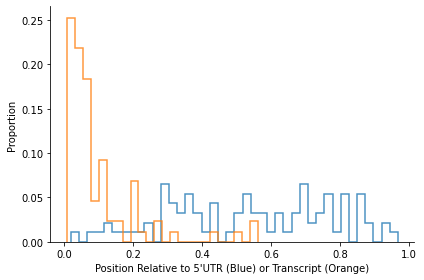

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)  

font = {'fontname':'Arial'}  
plt.rc('font',family='Arial')

noncanonical_dist=(np.array(distance_noncanonical)[index_include])/(np.array(upstream_lengths)[index_include])
ax.hist(noncanonical_dist,bins = 40,histtype=u'step',alpha=0.8, weights=np.ones(len(noncanonical_dist)) / len(noncanonical_dist),
          label = "Upstream noncanonical TICs (5'UTR)",linewidth=1.5)

canonical_dist = np.array(CDS_start_pos)/np.array(tot_lengths)
ax.hist(canonical_dist,bins = 24,histtype=u'step',alpha=.8,weights=np.ones(len(canonical_dist)) / len(canonical_dist),
          label = "Canonical TICs (full transcript)",linewidth=1.5)
#ax.set_title("\n".join(wrap("Position of Upstream Noncanonical TICs in the 5’UTR and Canonical TICs in the Full Transcript", 60)))

#Position of Upstream Noncanonical TICs Relative to 5'UTR, and Canonical TICs Relative to entire Transcript
#handles, labels = ax.get_legend_handles_labels()
#lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.18))

plt.ylabel("Proportion")
plt.xlabel("Position Relative to 5'UTR (Blue) or Transcript (Orange)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
#plt.savefig('Fig4.svg')
plt.show()



In [13]:
print(min(tot_lengths),np.median(tot_lengths),max(tot_lengths))

510 3351.0 14805


In [14]:
print(min(CDS_start_pos),np.median(CDS_start_pos),max(CDS_start_pos))

37 201.0 1286


In [15]:
print('Proportion of canonical TICs with no ATG codons upstream:', sum(np.array(codons_above_atg)==0)/len(codons_above_atg))

Proportion of canonical TICs with no ATG codons upstream: 0.632183908045977


In [16]:
print('median codons upstream of upstream noncanonical TIC:', np.median(codons_upstream))

median codons upstream of upstream noncanonical TIC: 13.0


In [17]:
data=[]
with  open('non_cancer_genes_all_data',"rb") as f:
    for _ in range(pickle.load(f)):
        data.append(pickle.load(f))

In [18]:
print("CANCER 5'UTR LENGTHS:")
print("median:",np.median(np.array(upstream_lengths)[index_include]))

CANCER 5'UTR LENGTHS:
median: 204.5


In [19]:
print("NON-CANCER 5'UTR LENGTHS:")
print("median:",np.median(data[0]))

NON-CANCER 5'UTR LENGTHS:
median: 112.0


In [20]:
stats.mannwhitneyu(np.array(upstream_lengths)[index_include],data[0],alternative="greater")

MannwhitneyuResult(statistic=227074.5, pvalue=9.959064870468575e-10)